##Домашнее задание №2

Педченко Андрей
MADE-ML-32

In [ ]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
import itertools
import tqdm
import copy

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

#from matplotlib import rc
#rc('font',**{'family':'sans-serif'})
#rc('text', usetex=True)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
#rc('figure', **{'dpi': 300})

## Реализуем крестики-нолики

In [ ]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [ ]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [ ]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        if pi.t == 'x':
            return np.argmax(pi.get_rewards_from_Q(s))
        else:
            return np.argmin(pi.get_rewards_from_Q(s))
        # return pi.getActionGreedy(s, len(actions))

In [ ]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

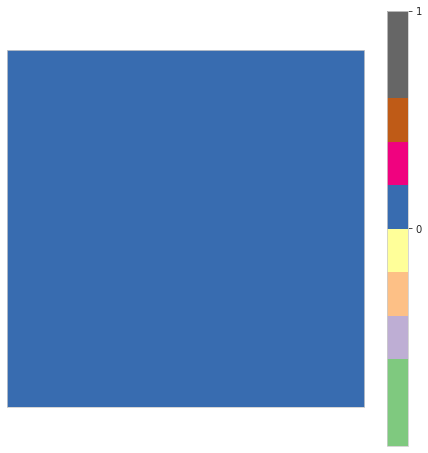

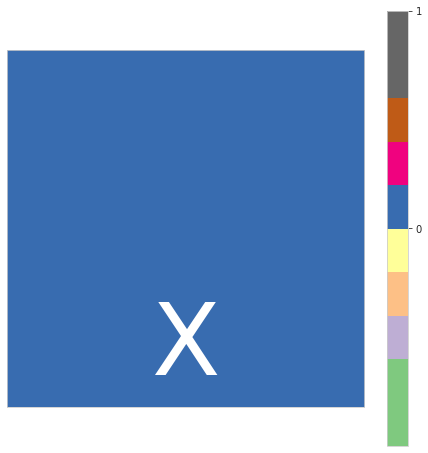

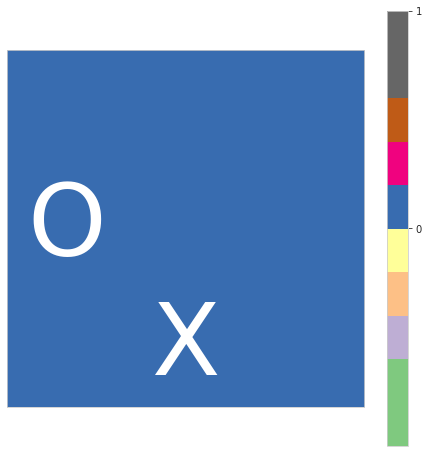

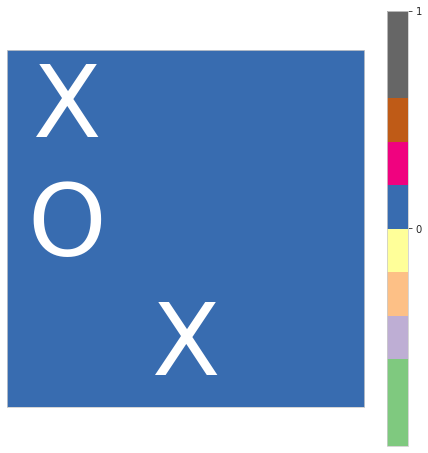

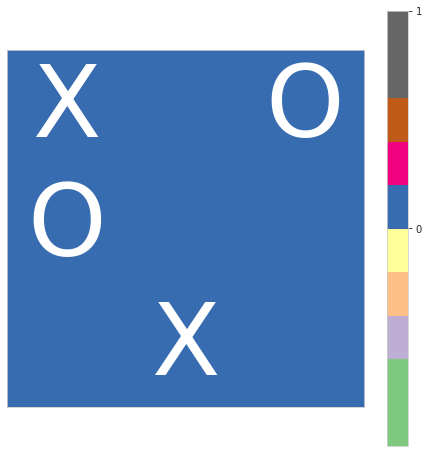

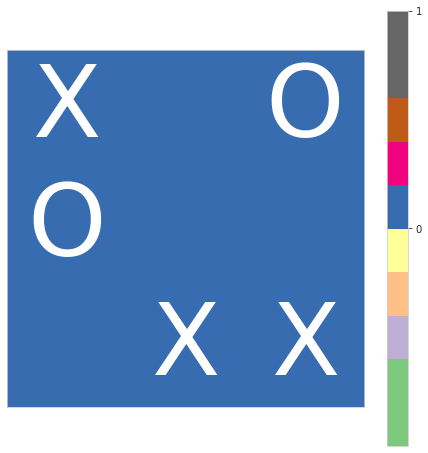

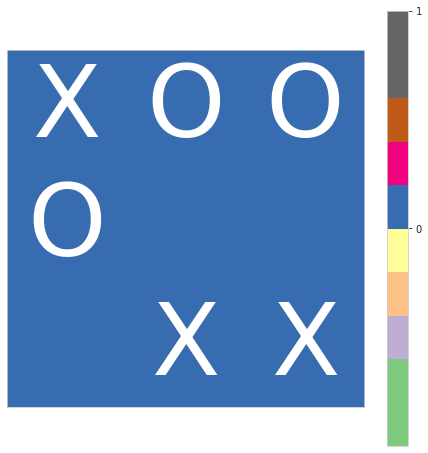

Крестики выиграли!


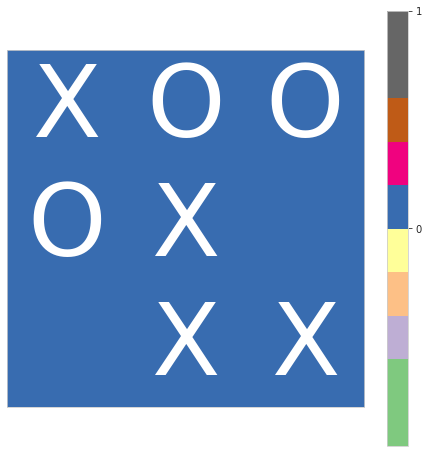

In [ ]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=100)

###Часть первая: крестики-нолики при помощи Q-обучения



В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

**Disclaimer**: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.



1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [ ]:
# Q-обучение взято из первого домашнего задания, так как там оно было принято

class QL:
  def __init__(self, alpha=0.005, epsilon=0.55, gamma=0.75, n_cols=3, n_rows=3, n_win=3, t='x'):
    self.Q = {}
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma
    self.n_cols = n_cols
    self.n_rows = n_rows
    self.n_win = n_win
    self.t = t

  def available_cells(self, state):
    n = int(self.n_cols * self.n_rows)
    return [i for i in range(n) if state[i] == '1']
      
  def get_rewards_from_Q(self, state):
    # print(state)
    if state not in self.Q:
      self.Q[state] = np.zeros(len(self.available_cells(state)))
    return self.Q[state]
  
  def get_reward_for_action_from_Q(self, state, action):
    return self.get_rewards_from_Q(state)[action]

  def learn_episode(self, steps, reward):
    for state, action in steps[::-1]:
      reward = self.get_reward_for_action_from_Q(state, action) + self.alpha * (reward + self.gamma * np.max(self.Q[state]) - self.get_reward_for_action_from_Q(state, action))
      self.Q[state][action] = reward

In [ ]:
# Отдельные функции для обучения и игры для крестиков

def q_learning_episode(env, ql):
  env.reset()
  state = env.getState()[0]
  final = False
  steps = []
  while not final:
    # print('i')
    if np.random.rand() <= ql.epsilon:
      action = random.choice(range(len(env.getEmptySpaces())))
      # print(action, 'rand')
    else:
      action = np.argmax(ql.get_rewards_from_Q(state))
    # print(ql.get_rewards_from_Q(state), state, action)
    steps.append((state, action))
    # print(env.getEmptySpaces()[action], action, ql.get_rewards_from_Q(state), state, np.argmax(ql.get_rewards_from_Q(state)))
    state, reward, final, _ = env.step(env.getEmptySpaces()[action])    
    state = state[0]
    if not final:
      action = random.choice(range(len(env.getEmptySpaces())))
      state, reward, final, _ = env.step(env.getEmptySpaces()[action])
      state = state[0]
  return steps, reward

In [ ]:
def q_playing_episode(env, ql):
  env.reset()
  state = env.getState()[0]
  final = False
  steps = []
  while not final:
    if state in ql.Q.keys():
      # print(state)
      action = np.argmax(ql.get_rewards_from_Q(state))
    else:
      # print('else')
      action = random.choice(range(len(env.getEmptySpaces())))
    steps.append((state, action))
    state, reward, final, _ = env.step(env.getEmptySpaces()[action])    
    state = state[0]
    if not final:
      action = random.choice(range(len(env.getEmptySpaces())))
      state, reward, final, _ = env.step(env.getEmptySpaces()[action])
      state = state[0]
  return steps, reward

In [ ]:
# search_params = {}

# for e in np.linspace(0.05, 1, 10):
#   for a in np.linspace(0.000001, 0.001, 10):
#     for g in np.linspace(0.05, 1, 10):
#       ql = QL(alpha=a, epsilon=e, gamma=g)
#       reward_for_plot = []
#       cum_reward = 0
#       for n in range(3000):
#         steps, reward = q_learning_episode(env, ql)
#         ql.learn_episode(steps, reward)
#         cum_reward += reward
#         reward_for_plot.append(cum_reward/(n + 1))
#       search_params[(a, e, g)] = np.mean(reward_for_plot[100:])

# import operator
# a, e, g = max(search_params.items(), key=operator.itemgetter(1))[0]
# print('Наиболее оптимальные параметры')
# print(a, e, g)

Сначала учим крестики

In [ ]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

a, e, g = 0.001, 0.05, 1.0

ql_x = QL(alpha=a, epsilon=e, gamma=g, t='x')
reward_for_plot = []
cum_reward = 0
for n in tqdm.tqdm_notebook(range(50000)):
  # print(n)
  steps, reward = q_learning_episode(env, ql_x)
  ql_x.learn_episode(steps, reward)
  cum_reward += reward
  reward_for_plot.append(cum_reward/(n + 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


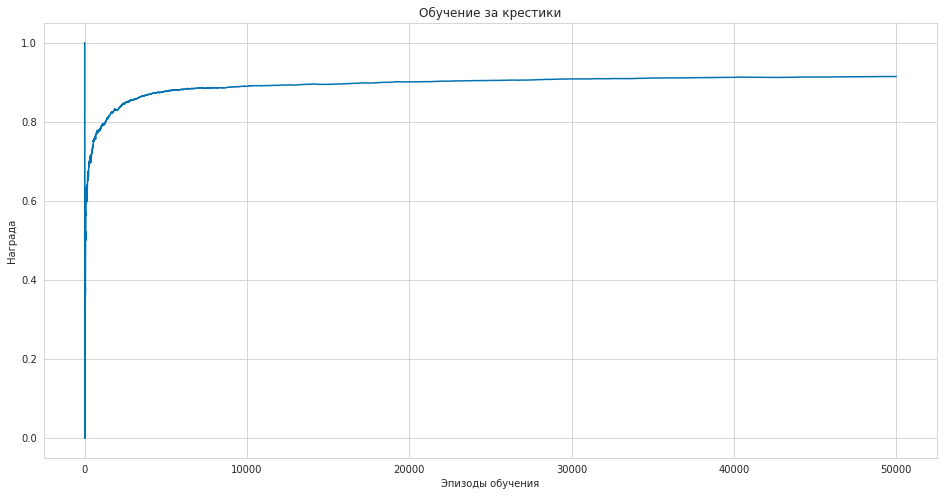

Средняя награда при Q-обучении около 0.895121653750044


In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(reward_for_plot)
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.title('Обучениe за крестики')
plt.show()
print("Средняя награда при Q-обучении около", np.mean(reward_for_plot))

Игра крестиков после обучения

In [ ]:
reward_for_plot = []
cum_reward = 0
for n in tqdm.tqdm_notebook(range(20000)):
  _, reward = q_playing_episode(env, ql_x)
  # ql_x.learn_episode(steps, reward)
  cum_reward += reward
  reward_for_plot.append(cum_reward/(n + 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


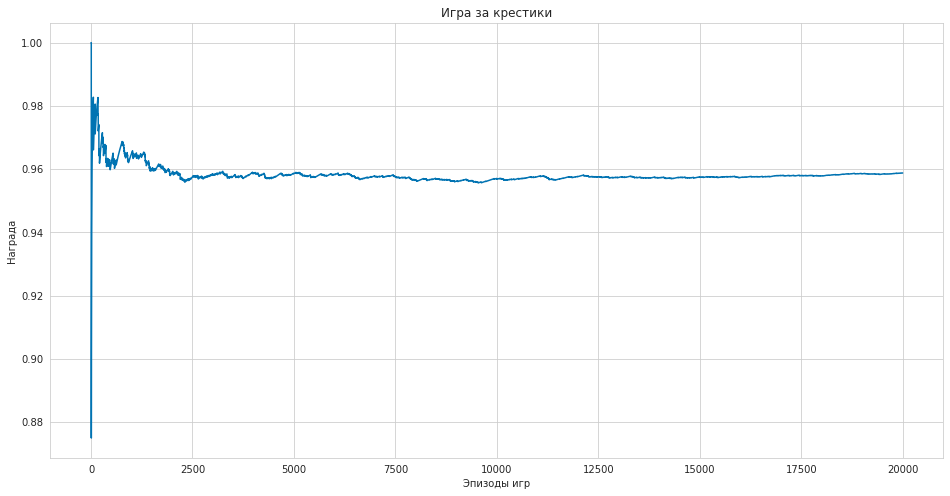

Средняя награда около 0.9582235820376108


In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(reward_for_plot)
plt.xlabel('Эпизоды игр')
plt.ylabel('Награда')
plt.title('Игра за крестики')
plt.show()
print("Средняя награда около", np.mean(reward_for_plot))

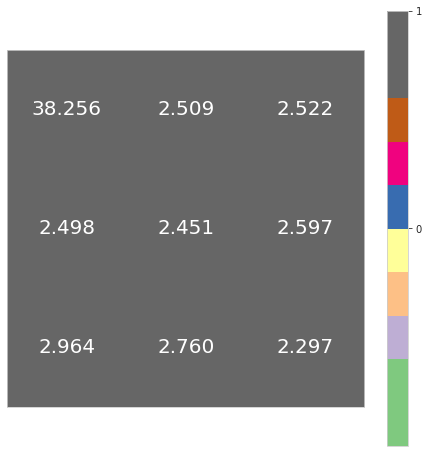

0 [0 0] 38.25641643008627
1 [0 1] 2.508544695375835
2 [0 2] 2.521973512734575
3 [1 0] 2.4981401890644936
4 [1 1] 2.451386937543745
5 [1 2] 2.596960643268915
6 [2 0] 2.9642481835707737
7 [2 1] 2.76012102980177
8 [2 2] 2.2969172004745495


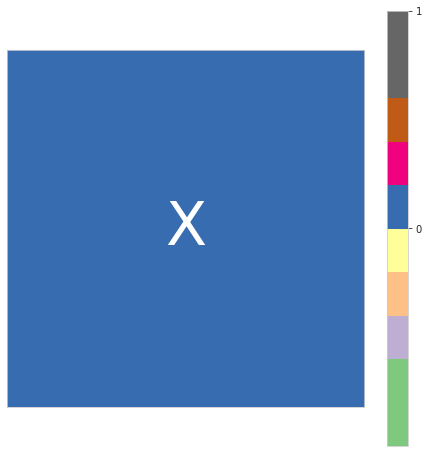

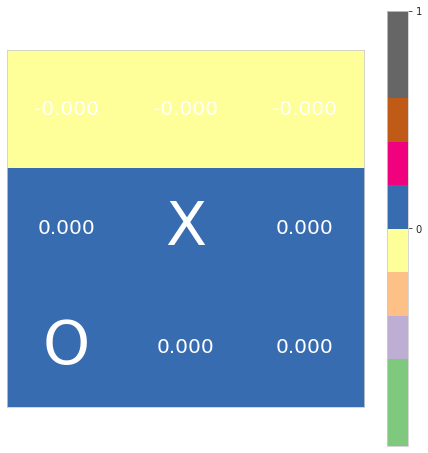

0 [0 0] -9.970000000000002e-07
1 [0 1] -1e-06
2 [0 2] -8.35194714e-07
3 [1 0] 7.189780142999999e-09
4 [1 2] 0.0
5 [2 1] 0.0
6 [2 2] 0.0


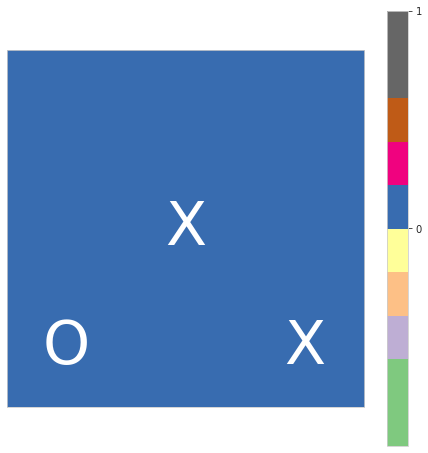

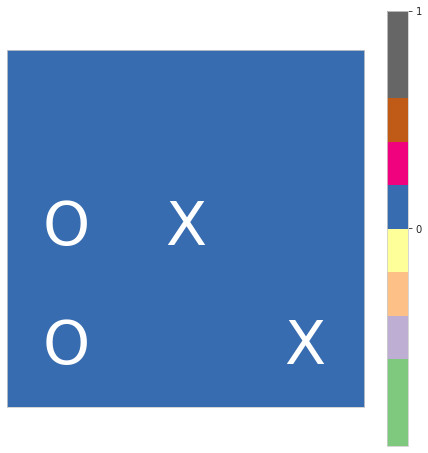

Стратегия не знает, что делать...
Крестики выиграли!


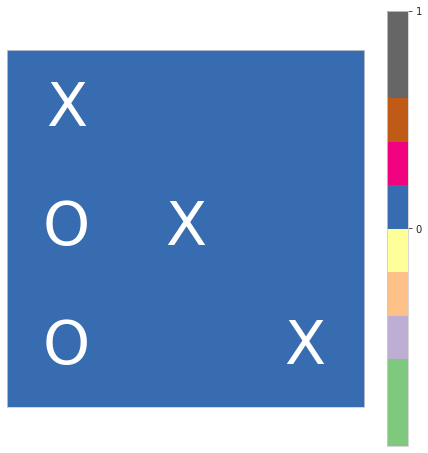

In [ ]:
plot_test_game(env, ql_x, None, random_crosses=True, random_naughts=True, verbose=True)

Теперь учим нолики. 

Из условий окружения в случае победы ноликов мы получаем -1, поэтому игры ноликов должны стремиться к -1.

In [ ]:
# Функции Q-обучения и игры для ноликов

def q_learning_episode_0(env, ql):
  env.reset()
  action = random.choice(range(len(env.getEmptySpaces())))
  state, reward, final, _ = env.step(env.getEmptySpaces()[action])
  state = state[0]
  final = False
  steps = []
  while not final:
    if np.random.rand() <= ql.epsilon:
      action = random.choice(range(len(env.getEmptySpaces())))
    else:
      action = np.argmin(ql.get_rewards_from_Q(state))
    steps.append((state, action))
    state, reward, final, _ = env.step(env.getEmptySpaces()[action])    
    state = state[0]
    if not final:
      action = random.choice(range(len(env.getEmptySpaces())))
      state, reward, final, _ = env.step(env.getEmptySpaces()[action])
      state = state[0]
  return steps, reward

def q_playing_episode_0(env, ql):
  env.reset()
  action = random.choice(range(len(env.getEmptySpaces())))
  state, reward, final, _ = env.step(env.getEmptySpaces()[action])
  state = state[0]
  final = False
  steps = []
  while not final:
    if state in ql.Q.keys():
      # print(state)
      action = np.argmin(ql.get_rewards_from_Q(state))
    else:
      # print('else')
      action = random.choice(range(len(env.getEmptySpaces())))
    steps.append((state, action))
    state, reward, final, _ = env.step(env.getEmptySpaces()[action])    
    state = state[0]
    if not final:
      action = random.choice(range(len(env.getEmptySpaces())))
      state, reward, final, _ = env.step(env.getEmptySpaces()[action])
      state = state[0]
  return steps, reward

In [ ]:
ql_0 = QL(alpha=a, epsilon=e, gamma=g, t=0)
reward_for_plot = []
cum_reward = 0
for n in tqdm.tqdm_notebook(range(200000)):
  # print(n)
  steps, reward = q_learning_episode_0(env, ql_0)
  ql_0.learn_episode(steps, reward)
  cum_reward += reward
  reward_for_plot.append(cum_reward/(n + 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


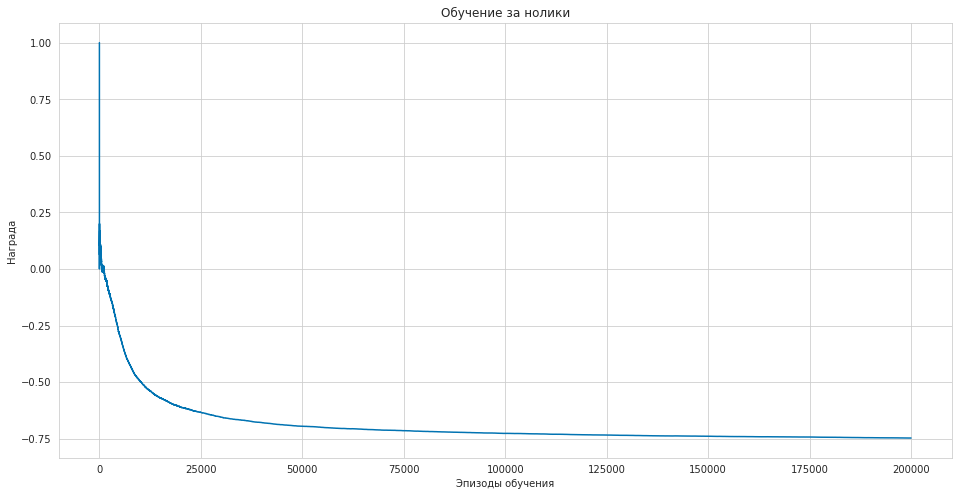

Средняя награда при Q-обучении около -0.6883911287318614


In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(reward_for_plot)
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.title('Обучениe за нолики')
plt.show()
print("Средняя награда при Q-обучении около", np.mean(reward_for_plot))

Игра ноликов после обучения

In [ ]:
reward_for_plot = []
cum_reward = 0
for n in tqdm.tqdm_notebook(range(20000)):
  _, reward = q_playing_episode_0(env, ql_0)
  cum_reward += reward
  reward_for_plot.append(cum_reward/(n + 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


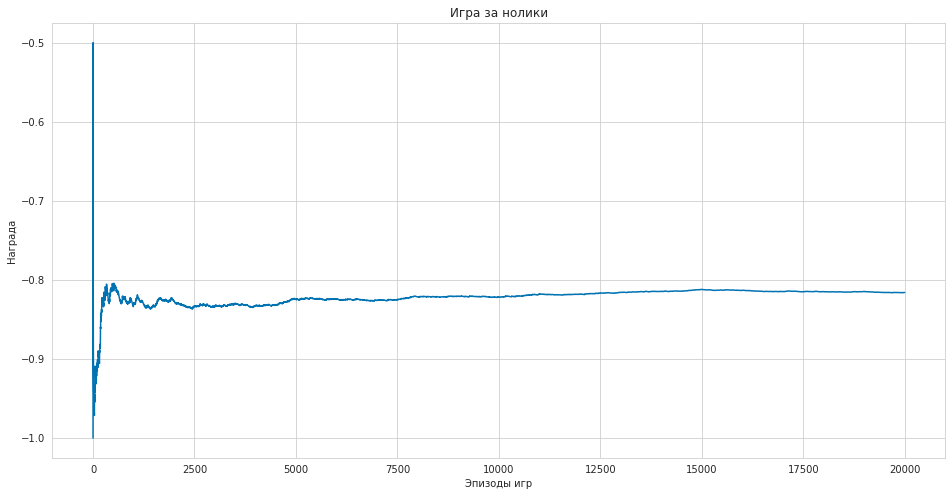

Средняя награда около -0.8217040974779791


In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(reward_for_plot)
plt.xlabel('Эпизоды игр')
plt.ylabel('Награда')
plt.title('Игра за нолики')
plt.show()
print("Средняя награда около", np.mean(reward_for_plot))

Ноликам трудновато приходится, наверно, из-за особенностей игры. Крестики ходят первыми, а первый ход тут многое решает.

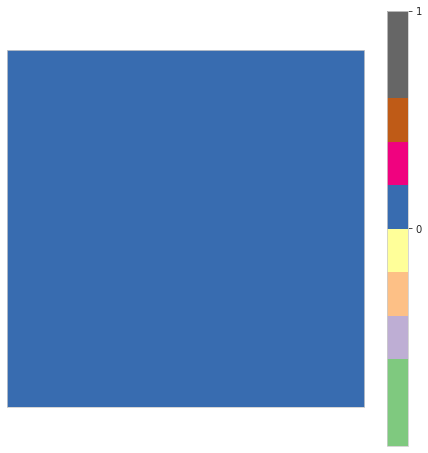

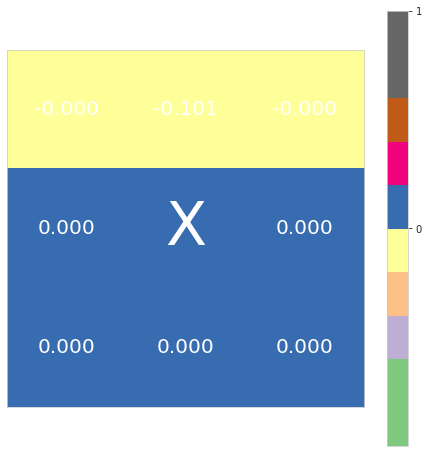

0 [0 0] -0.00017829685968443425
1 [0 1] -0.10113371063780031
2 [0 2] -2.8463985200695346e-05
3 [1 0] 2.5030680174025013e-06
4 [1 2] 1.225978804111937e-05
5 [2 0] 8.660624474139556e-06
6 [2 1] 1.7210384055781043e-05
7 [2 2] 1.149643825028631e-05


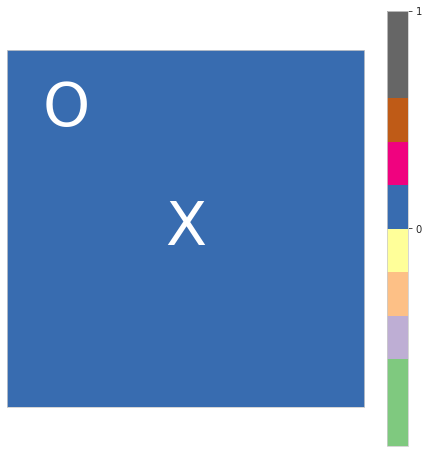

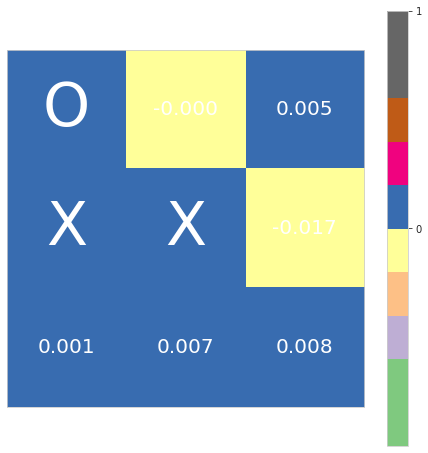

0 [0 1] -0.00042497363114760476
1 [0 2] 0.004658430307189562
2 [1 2] -0.01663051316272146
3 [2 0] 0.0011253670264690866
4 [2 1] 0.007015596039224225
5 [2 2] 0.008440107725664317


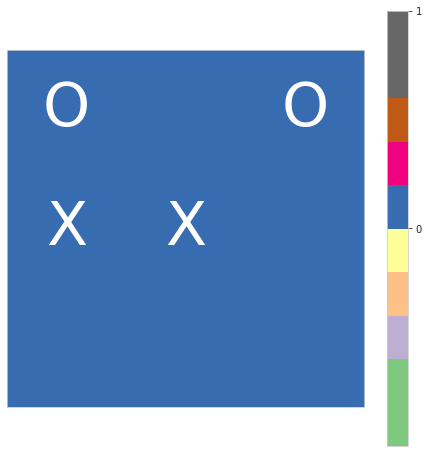

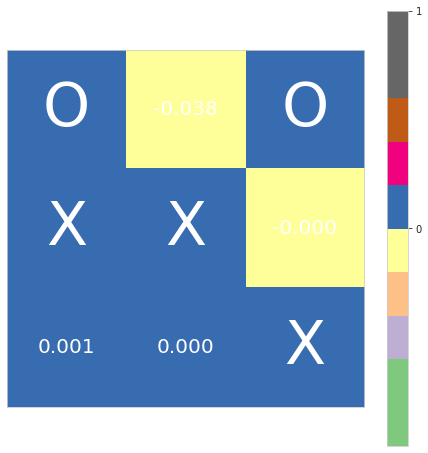

0 [0 1] -0.03823848828877277
1 [1 2] -2.9940039990000003e-06
2 [2 0] 0.001
3 [2 1] 0.0


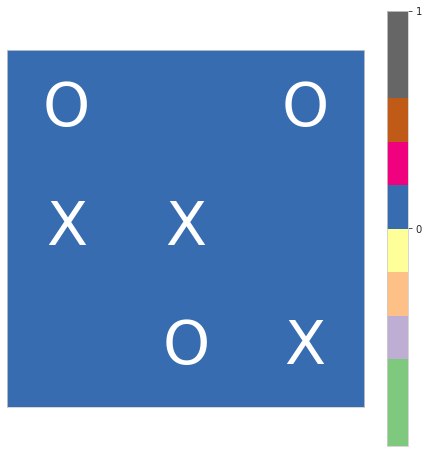

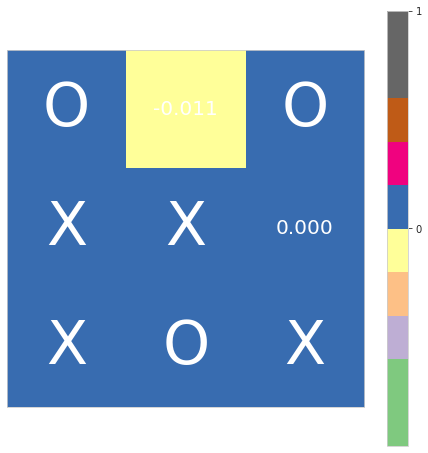

0 [0 1] -0.010945164670461537
1 [1 2] 0.0
Нолики выиграли!


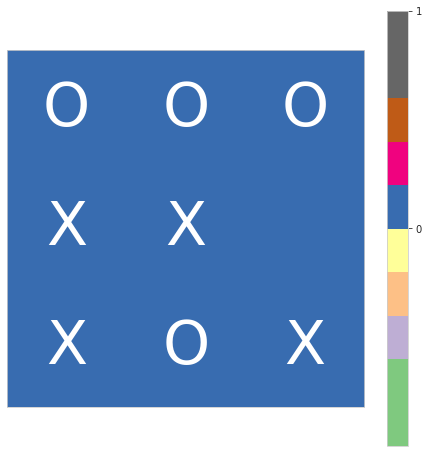

In [ ]:
plot_test_game(env, None, ql_0, random_crosses=True, random_naughts=True, verbose=True)

Один агент против другого

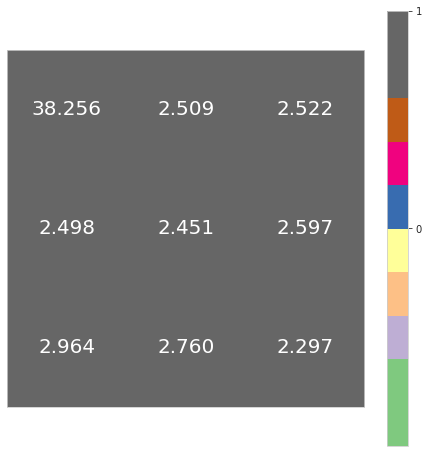

0 [0 0] 38.25641643008627
1 [0 1] 2.508544695375835
2 [0 2] 2.521973512734575
3 [1 0] 2.4981401890644936
4 [1 1] 2.451386937543745
5 [1 2] 2.596960643268915
6 [2 0] 2.9642481835707737
7 [2 1] 2.76012102980177
8 [2 2] 2.2969172004745495


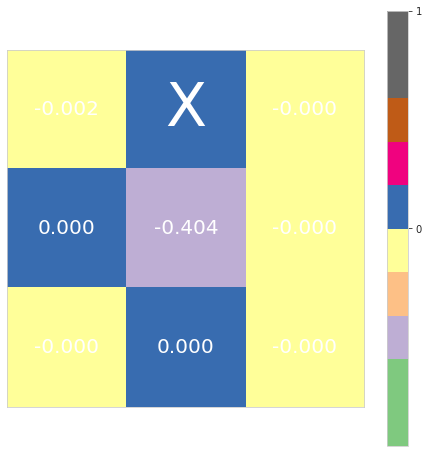

0 [0 0] -0.002182703922474614
1 [0 2] -7.810181933374349e-05
2 [1 0] 3.326027235728782e-06
3 [1 1] -0.4039260191486044
4 [1 2] -6.958796199409088e-06
5 [2 0] -9.856353923049935e-05
6 [2 1] 5.469826213456042e-06
7 [2 2] -0.0001585465391481612


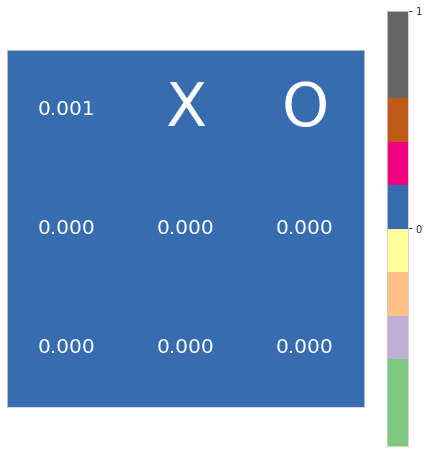

0 [0 0] 0.0006797485188538606
1 [1 0] 1.473497925160142e-07
2 [1 1] 0.0
3 [1 2] 0.0
4 [2 0] 0.0
5 [2 1] 0.0
6 [2 2] 0.0


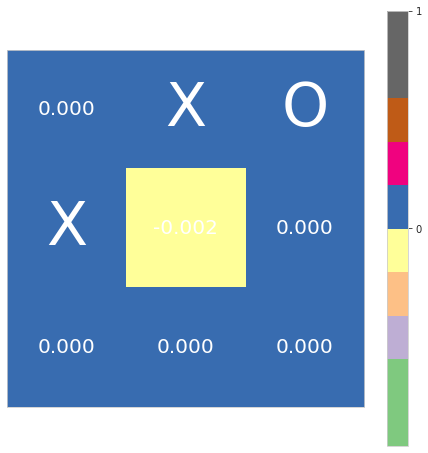

0 [0 0] 1.974156573800853e-06
1 [1 1] -0.0016402613500398518
2 [1 2] 0.0
3 [2 0] 0.0
4 [2 1] 0.0
5 [2 2] 0.0


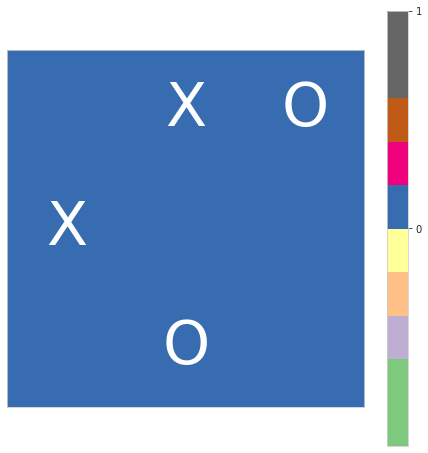

Стратегия не знает, что делать...


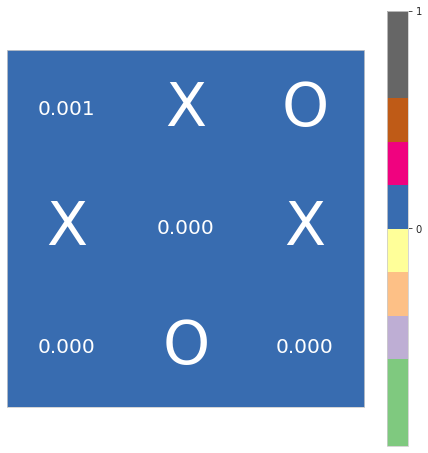

0 [0 0] 0.001
1 [1 1] 1e-06
2 [2 0] 2e-06
3 [2 2] 3.002998001e-06


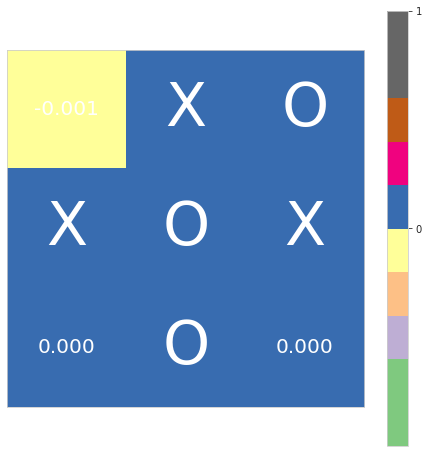

0 [0 0] -0.001
1 [2 0] 0.0
2 [2 2] 0.0


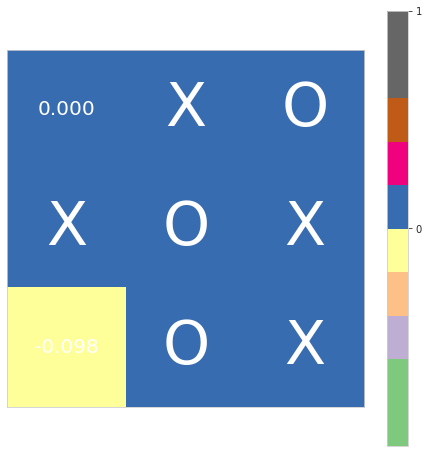

0 [0 0] 0.0
1 [2 0] -0.09791951585598288
Нолики выиграли!


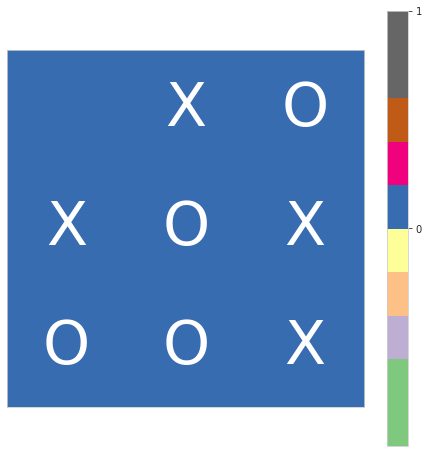

In [ ]:
plot_test_game(env, ql_x, ql_0, random_crosses=True, random_naughts=True, verbose=True)

2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Учим 4х4

Крестики

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


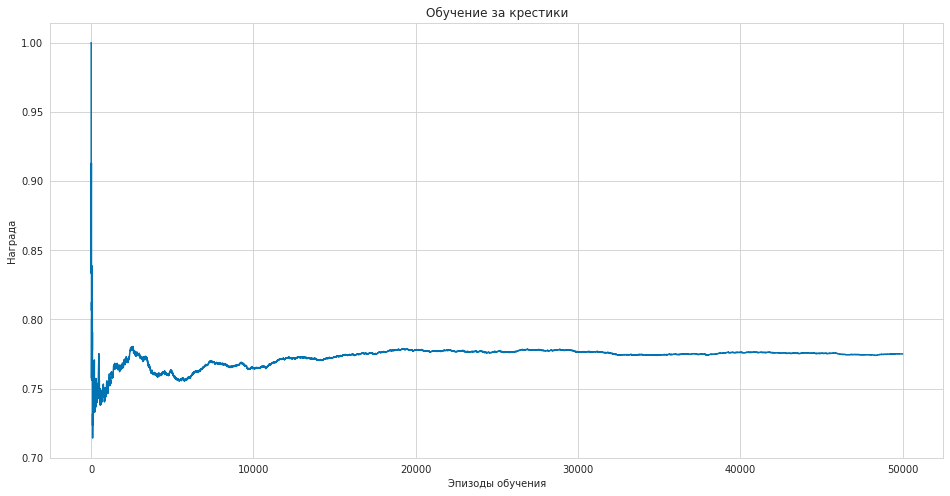

Средняя награда при Q-обучении около 0.7729818848663826


In [ ]:
env = TicTacToe(n_rows=5, n_cols=5, n_win=4)

a, e, g = 0.001, 0.05, 1.0

ql_x = QL(alpha=a, epsilon=e, gamma=g, n_cols=5, n_rows=5, n_win=4, t='x')
reward_for_plot = []
cum_reward = 0
for n in tqdm.tqdm_notebook(range(50000)):
  steps, reward = q_learning_episode(env, ql_x)
  ql_x.learn_episode(steps, reward)
  cum_reward += reward
  reward_for_plot.append(cum_reward/(n + 1))

plt.figure(figsize=(16, 8))
plt.plot(reward_for_plot)
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.title('Обучениe за крестики')
plt.show()
print("Средняя награда при Q-обучении около", np.mean(reward_for_plot))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


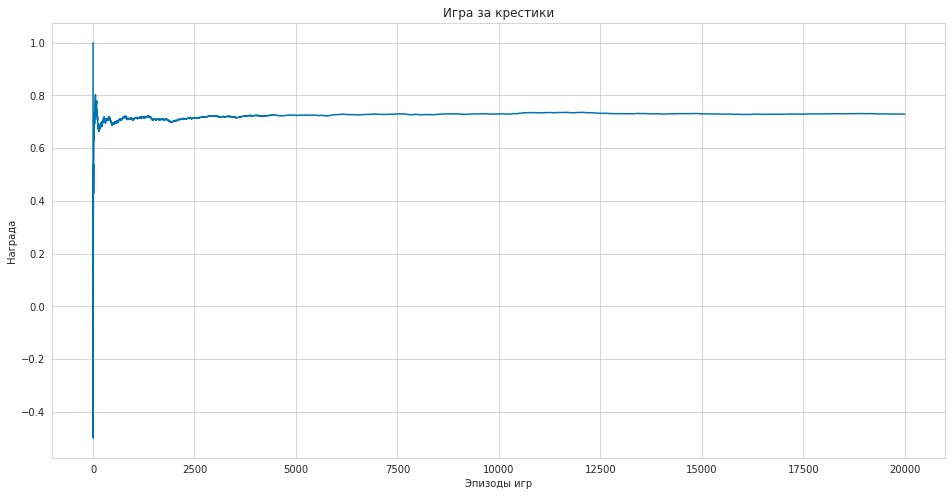

Средняя награда около 0.7256928084281459


In [ ]:
reward_for_plot = []
cum_reward = 0
for n in tqdm.tqdm_notebook(range(20000)):
  _, reward = q_playing_episode(env, ql_x)
  # ql_x.learn_episode(steps, reward)
  cum_reward += reward
  reward_for_plot.append(cum_reward/(n + 1))

plt.figure(figsize=(16, 8))
plt.plot(reward_for_plot)
plt.xlabel('Эпизоды игр')
plt.ylabel('Награда')
plt.title('Игра за крестики')
plt.show()
print("Средняя награда около", np.mean(reward_for_plot))

На большом поле награды пониже, но тоже достойно.

Нолики

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


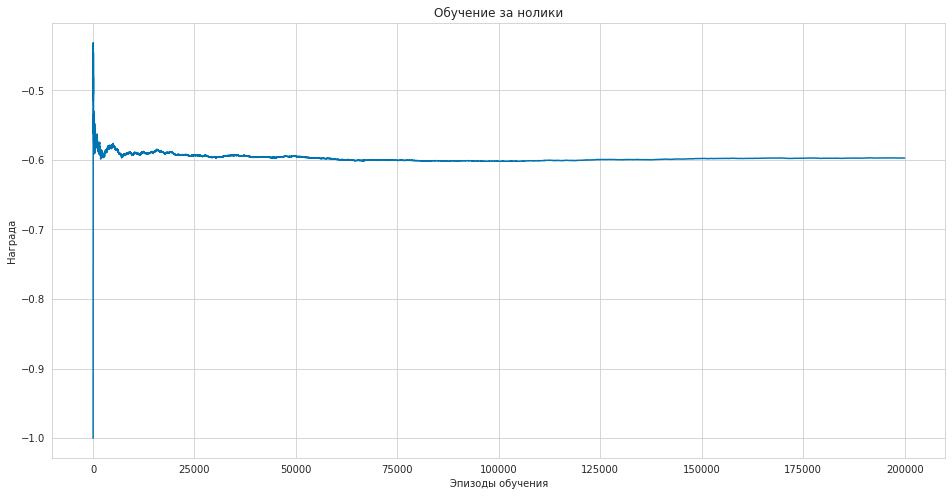

Средняя награда при Q-обучении около -0.5974186848741072


In [ ]:
ql_0 = QL(alpha=a, epsilon=e, gamma=g, n_cols=5, n_rows=5, n_win=4, t=0)
reward_for_plot = []
cum_reward = 0
for n in tqdm.tqdm_notebook(range(200000)):
  # print(n)
  steps, reward = q_learning_episode_0(env, ql_0)
  ql_0.learn_episode(steps, reward)
  cum_reward += reward
  reward_for_plot.append(cum_reward/(n + 1))

plt.figure(figsize=(16, 8))
plt.plot(reward_for_plot)
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.title('Обучениe за нолики')
plt.show()
print("Средняя награда при Q-обучении около", np.mean(reward_for_plot))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


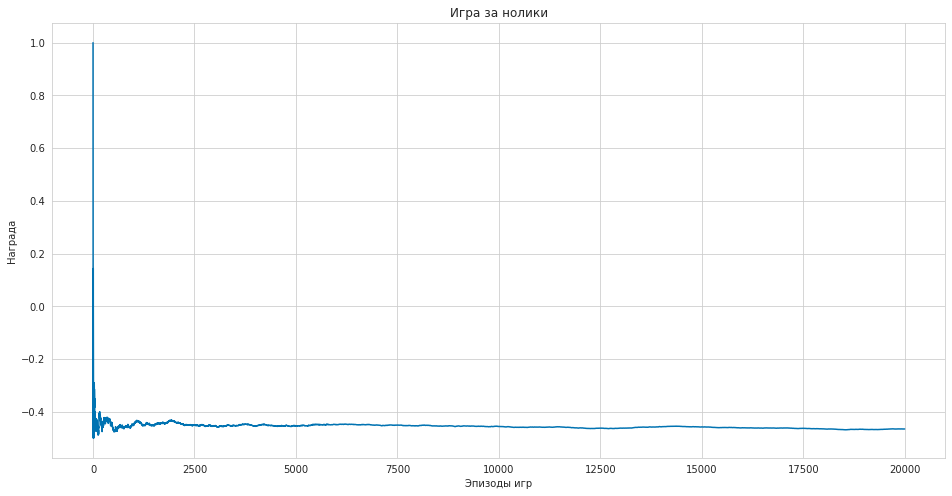

Средняя награда около -0.4559825517787494


In [ ]:
reward_for_plot = []
cum_reward = 0
for n in tqdm.tqdm_notebook(range(20000)):
  _, reward = q_playing_episode_0(env, ql_0)
  cum_reward += reward
  reward_for_plot.append(cum_reward/(n + 1))

plt.figure(figsize=(16, 8))
plt.plot(reward_for_plot)
plt.xlabel('Эпизоды игр')
plt.ylabel('Награда')
plt.title('Игра за нолики')
plt.show()
print("Средняя награда около", np.mean(reward_for_plot))

Нолики на большом поле надо прям долго учить

Сталкиваем агентов

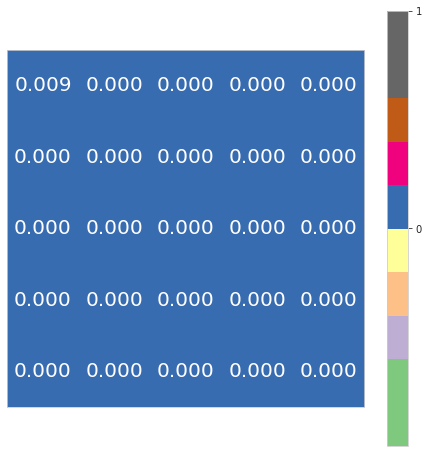

0 [0 0] 0.009080984650486654
1 [0 1] 0.0001737022532103896
2 [0 2] 0.00017327766024152026
3 [0 3] 0.00016434319428365135
4 [0 4] 0.00016786249729432558
5 [1 0] 0.00023357177865601048
6 [1 1] 0.00011303859373322193
7 [1 2] 0.00021593052047532668
8 [1 3] 0.0001446217648003337
9 [1 4] 0.00023319796637131938
10 [2 0] 0.00017990189598226548
11 [2 1] 0.00018970819349091924
12 [2 2] 0.00022364222590717645
13 [2 3] 0.00015560092340591072
14 [2 4] 0.00017066079657321494
15 [3 0] 0.00019242317303394858
16 [3 1] 0.00018693468542490705
17 [3 2] 0.0001840937165383254
18 [3 3] 0.00018673411929186754
19 [3 4] 0.00019160250196060367
20 [4 0] 0.00013475126585477454
21 [4 1] 0.00018621892073666552
22 [4 2] 0.00021607385742428544
23 [4 3] 0.00014526642139583374
24 [4 4] 0.0001995411607451339


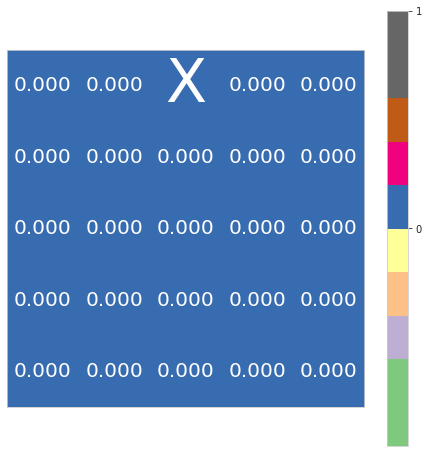

0 [0 0] 3.057951941232037e-10
1 [0 1] 3.0541349934568965e-10
2 [0 3] 1.0831151419089061e-09
3 [0 4] 3.0571844037954266e-10
4 [1 0] 3.0510038066796546e-10
5 [1 1] 3.0509595234106373e-10
6 [1 2] 3.060215072006921e-10
7 [1 3] 3.059648027432618e-10
8 [1 4] 3.052355489180843e-10
9 [2 0] 3.0584989980027983e-10
10 [2 1] 3.0511312482197197e-10
11 [2 2] 3.058101661088309e-10
12 [2 3] 3.0506702196561205e-10
13 [2 4] 3.058445612999874e-10
14 [3 0] 1.0011959141075636e-09
15 [3 1] 3.0556981892724594e-10
16 [3 2] 3.0587211787658346e-10
17 [3 3] 1.2910758753924562e-09
18 [3 4] 3.0507596172211816e-10
19 [4 0] 3.050419787030894e-10
20 [4 1] 1.2201454509102349e-09
21 [4 2] 1.2633819813017573e-09
22 [4 3] 3.0597517506951003e-10
23 [4 4] 3.050684083500509e-10


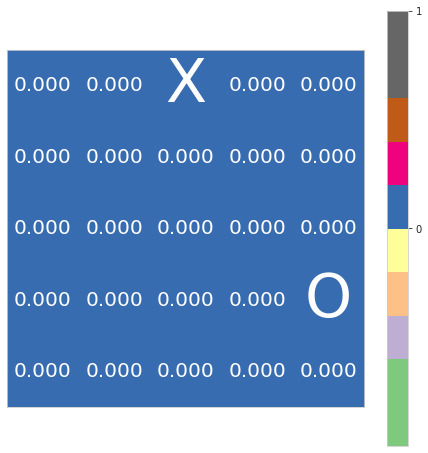

0 [0 0] 8.004e-09
1 [0 1] 0.0
2 [0 3] 0.0
3 [0 4] 0.0
4 [1 0] 0.0
5 [1 1] 0.0
6 [1 2] 0.0
7 [1 3] 0.0
8 [1 4] 0.0
9 [2 0] 0.0
10 [2 1] 0.0
11 [2 2] 0.0
12 [2 3] 0.0
13 [2 4] 0.0
14 [3 0] 0.0
15 [3 1] 0.0
16 [3 2] 0.0
17 [3 3] 0.0
18 [4 0] 0.0
19 [4 1] 0.0
20 [4 2] 0.0
21 [4 3] 0.0
22 [4 4] 0.0


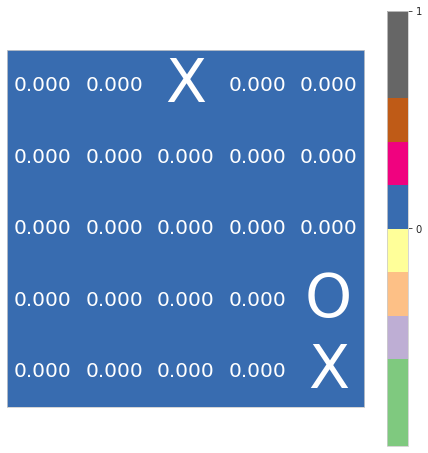

0 [0 0] 1.0000000000000003e-24
1 [0 1] 2.999018845540946e-21
2 [0 3] 1.0010000000000003e-24
3 [0 4] 1.999018845540946e-24
4 [1 0] 1.999018845540946e-24
5 [1 1] 2.999018846540946e-24
6 [1 2] 0.0
7 [1 3] 0.0
8 [1 4] 0.0
9 [2 0] 0.0
10 [2 1] 0.0
11 [2 2] 0.0
12 [2 3] 0.0
13 [2 4] 0.0
14 [3 0] 0.0
15 [3 1] 0.0
16 [3 2] 0.0
17 [3 3] 0.0
18 [4 0] 0.0
19 [4 1] 0.0
20 [4 2] 0.0
21 [4 3] 0.0


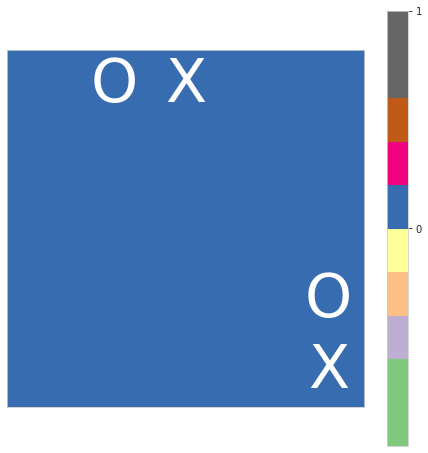

Стратегия не знает, что делать...


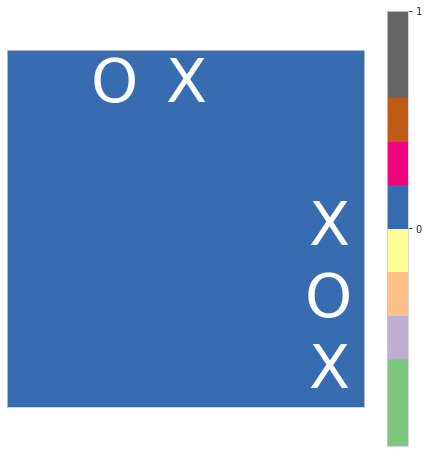

Стратегия не знает, что делать...


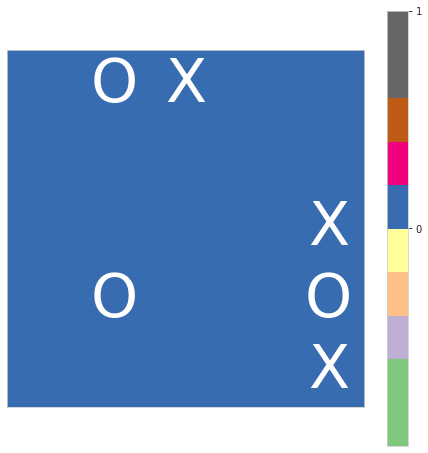

Стратегия не знает, что делать...


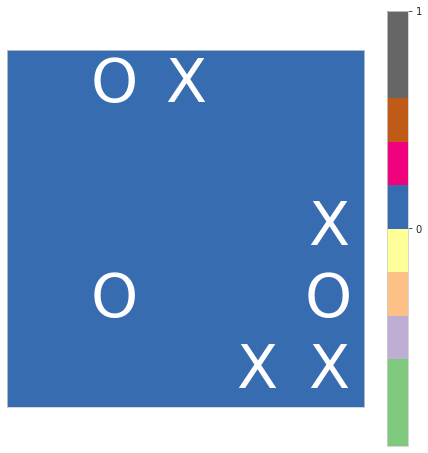

Стратегия не знает, что делать...


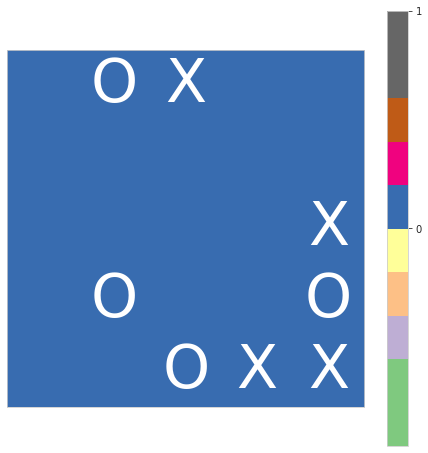

Стратегия не знает, что делать...


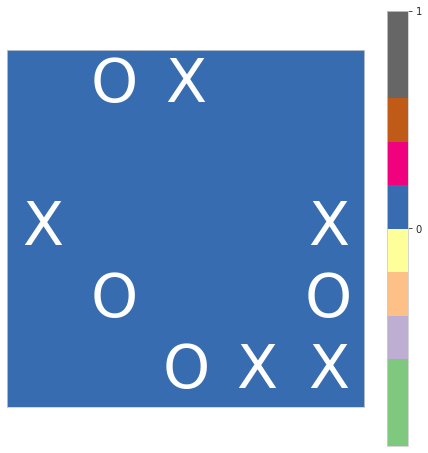

Стратегия не знает, что делать...


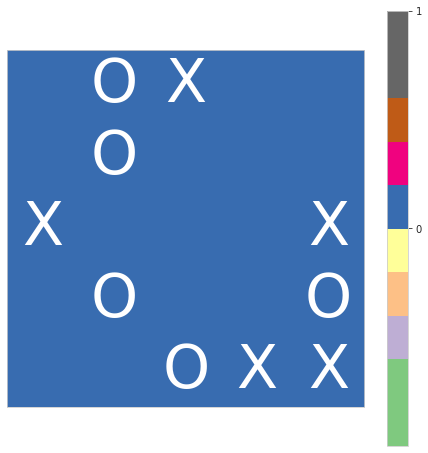

Стратегия не знает, что делать...


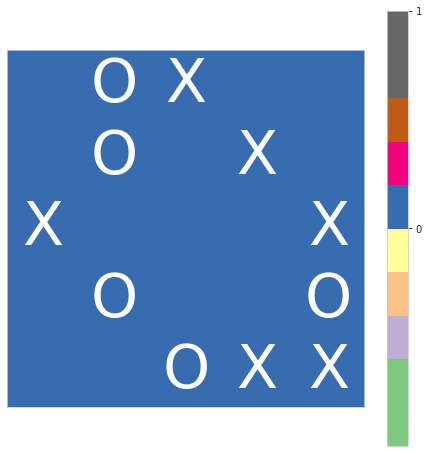

Стратегия не знает, что делать...
Нолики выиграли!


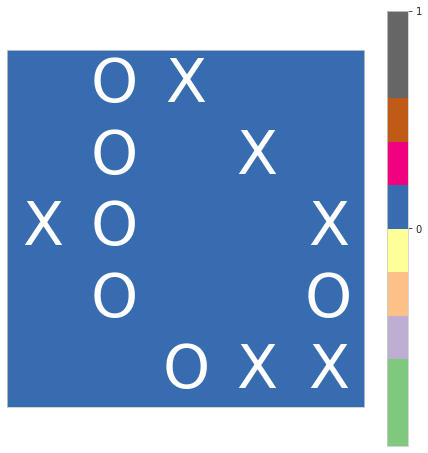

In [ ]:
plot_test_game(env, ql_x, ql_0, random_crosses=True, random_naughts=True, verbose=True)

##Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).
3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
4. Реализуйте Double DQN и/или Dueling DQN.







3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [ ]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

In [ ]:
# Сергей, спасибо вам за ноутбук с подходящим кодом

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [ ]:
class Model_3x3(nn.Module):
    def __init__(self, conv_out=128):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, conv_out * 2, (3, 3))
        self.lin1 = nn.Linear(conv_out * 2, conv_out)
        self.lin2 = nn.Linear(conv_out, 9)

    def forward(self, state):
        x = F.relu(self.conv(state))
        x = torch.flatten(x, 1)
        x = F.relu(self.lin1(x))
        qvals = self.lin2(x)
        return qvals

In [ ]:
def state_to_torch(text_state):
    s = np.array([int(c) for c in text_state])
    size = int(np.sqrt(len(s)))
    crosses = np.where(s==2, 1, 0).reshape(size, size)
    noughts = np.where(s==0, 1, 0).reshape(size, size)
    empty_spaces = np.where(s==1, 1, 0).reshape(size, size)
    return torch.Tensor(np.stack([crosses, noughts, empty_spaces])).reshape(1, 3, size, size)

In [ ]:
# Из-за того, что ql-класс проще было взять из первой домашки, выше обучал крестики и нолики порознь. 
# Теперь попробую обучать их как бы вместе; прям друг с другом они не играют.
# И из-за того, что учу их одними и теми же функциями теперь, награды ноликов инвертирую.

class TicTacToeDQN():
    def __init__(self, model=Model_3x3):
        self.env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
        self.model_x = model()
        self.model_0 = model()
        self.memory_x = ReplayMemory(10000)
        self.memory_0 = ReplayMemory(10000)
        self.optimizer_x = optim.Adam(self.model_x.parameters(), 0.001)
        self.optimizer_0 = optim.Adam(self.model_0.parameters(), 0.001)
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        
        self.available_states = list((i, j) for i in range(self.env.n_rows) for j in range(self.env.n_cols))
        
    def select_greedy_action(self, state, model):
        return model(state).data.max(1)[1].view(1, 1)
    
    def select_action(self, state, model):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, model)
        else:
            return torch.tensor([[random.choice(range(len(env.getEmptySpaces())))]], dtype=torch.int64)
            
    def run_episode(self, do_learning=True, greedy=False):
        self.env.reset()
        # прогон крестиков
        state_x = self.env.getState()[0]
        state = state_to_torch(state_x)
        done = False
        while not done:
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state, self.model_x)
                else:
                    action = self.select_action(state, self.model_x)
            # print(action, self.available_states)
            (next_state, available_steps, _), reward, done, _ = self.env.step(self.available_states[action.numpy()[0][0]])
            if done:
                next_state = state_to_torch(next_state)
                transition = (state, action, next_state, torch.tensor([reward], dtype=torch.float32))
                self.memory_x.store(transition)
                break
            compet_action = tuple(available_steps[np.random.randint(0, len(available_steps))])
            (next_state, _, _), reward, done, _ = self.env.step(compet_action)
            next_state = state_to_torch(next_state)
            transition = (state, action, next_state, torch.tensor([reward], dtype=torch.float32))
            self.memory_x.store(transition)
            state = next_state
        
        # прогон ноликов
        self.env.reset()
        state_x = self.env.getState()[0]
        action_x = tuple(self.available_states[np.random.randint(0, len(self.available_states))])
        state_0 = self.env.step(action_x)[0][0]
        state = state_to_torch(state_0)
        done = False
        while not done:
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state, self.model_0)
                else:
                    action = self.select_action(state, self.model_0)
            # print(action, self.available_states)
            (next_state, available_steps, _), reward, done, _ = self.env.step(self.available_states[action.numpy()[0][0]])
            if int(abs(reward)) == 1:
                reward *= -1
            if done:
                next_state = state_to_torch(next_state)
                transition = (state, action, next_state, torch.tensor([reward], dtype=torch.float32))
                self.memory_0.store(transition)
                break
            compet_action = tuple(available_steps[np.random.randint(0, len(available_steps))])
            (next_state, _, _), reward, done, _ = self.env.step(compet_action)
            next_state = state_to_torch(next_state)
            if int(abs(reward)) == 1:
                reward *= -1
            transition = (state, action, next_state, torch.tensor([reward], dtype=torch.float32))
            self.memory_0.store(transition)
            state = next_state

        if do_learning:
            self.learn()
                
    def learn_model(self, model, memory, optimizer):
        if len(memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    def learn(self):
        self.learn_model(self.model_x, self.memory_x, self.optimizer_x)
        self.learn_model(self.model_0, self.memory_0, self.optimizer_0)

In [ ]:
def play_game(dqn, n_games):
        
    results = []
    
    # прогон для крестиков
    env = dqn.env
    res = 0
    for _ in range(n_games):
        env.reset()
        state_x = env.getState()[0]
        done = False
        while not done:
            available_states = env.getEmptySpaces()
            action_x = dqn.available_states[dqn.select_greedy_action(state_to_torch(state_x), dqn.model_x).numpy()[0][0]]
            state_0, reward, done, _ = env.step(action_x)
            state_0 = state_0[0]
            if not done:
                available_states = env.getEmptySpaces()
                action_0 = tuple(available_states[np.random.randint(0, len(available_states))])
                state_x, reward, done, _ = env.step(action_0)
                state_x = state_x[0]
        res += reward
    res /= n_games
    results.append(res)

    # прогон для ноликов
    res = 0
    for _ in range(n_games):
        env.reset()
        state_x = env.getState()[0]
        done = False
        while not done:
            available_states = env.getEmptySpaces()
            action_x = tuple(available_states[np.random.randint(0, len(available_states))])
            state_0, reward, done, _ = env.step(action_x)
            state_0 = state_0[0]
            if not done:
                available_states = env.getEmptySpaces()
                action_0 = dqn.available_states[dqn.select_greedy_action(state_to_torch(state_0), dqn.model_0).numpy()[0][0]]
                state_x, reward, done, _ = env.step(action_0)
                state_x = state_x[0]
        if reward != -10:
            reward *= -1
        res += reward
    res /= n_games
    results.append(res)

    return results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Эпизод 0 Крестики -10.0 Нолики -9.748
Эпизод 4000 Крестики 0.87 Нолики 0.084
Эпизод 8000 Крестики 0.832 Нолики 0.566
Эпизод 12000 Крестики 0.804 Нолики 0.464
Эпизод 16000 Крестики 0.84 Нолики 0.57



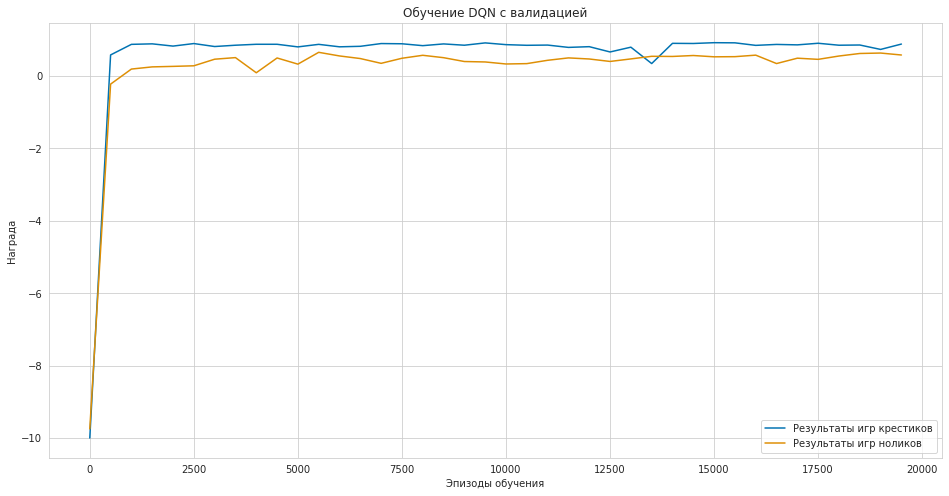

Эпизод 20000 Крестики 0.876 Нолики 0.574


In [ ]:
# Учим и иногда проверяем результаты на реальных играх

dqn = TicTacToeDQN(Model_3x3)

episod = 0
results_x = []
results_0 = []
episodes = []
for i in tqdm.tqdm_notebook(range(20000)):
    dqn.run_episode(do_learning=True)
    if i % 500 == 0:
        with torch.no_grad():
            results_x_, results_0_ = play_game(dqn, 500)
        results_x.append(results_x_)
        results_0.append(results_0_)
        episodes.append(episod)
        if i % 4000 == 0:
            print('Эпизод {}'.format(episod), 'Крестики {}'.format(results_x_), 'Нолики {}'.format(results_0_))
        episod += 500
plt.figure(figsize=(16, 8))
plt.plot(episodes, results_x, label='Результаты игр крестиков')
plt.plot(episodes, results_0, label='Результаты игр ноликов')
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.title('Обучение DQN с валидацией')
plt.legend()
plt.show()
print('Эпизод {}'.format(episod), 'Крестики {}'.format(results_x_), 'Нолики {}'.format(results_0_))

Ноликам и тут сложновато

4. Реализуйте Double DQN и/или Dueling DQN.

In [ ]:
class Model_3x3_Dueling(nn.Module):
    def __init__(self, conv_out=128):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, conv_out * 2, (3, 3))
        self.lin = nn.Linear(conv_out * 2, conv_out)
        self.value_stream = nn.Linear(conv_out, 1)
        self.advantage_stream = nn.Linear(conv_out, 9)

    def forward(self, state):
        features = F.relu(self.conv(state))
        features = torch.flatten(features, 1)
        features = F.relu(self.lin(features))
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return qvals

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Эпизод 0 Крестики -10.0 Нолики -9.442
Эпизод 4000 Крестики 0.848 Нолики 0.168
Эпизод 8000 Крестики 0.826 Нолики 0.48
Эпизод 12000 Крестики 0.882 Нолики 0.576
Эпизод 16000 Крестики 0.874 Нолики 0.586



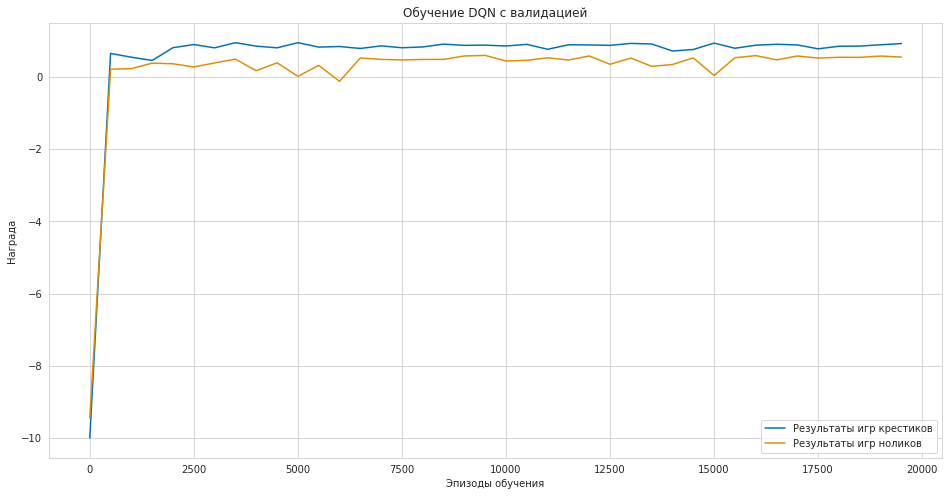

Эпизод 20000 Крестики 0.92 Нолики 0.544


In [ ]:
dqn = TicTacToeDQN(Model_3x3_Dueling)

episod = 0
results_x = []
results_0 = []
episodes = []
for i in tqdm.tqdm_notebook(range(20000)):
    dqn.run_episode(do_learning=True)
    if i % 500 == 0:
        with torch.no_grad():
            results_x_, results_0_ = play_game(dqn, 500)
        results_x.append(results_x_)
        results_0.append(results_0_)
        episodes.append(episod)
        if i % 4000 == 0:
            print('Эпизод {}'.format(episod), 'Крестики {}'.format(results_x_), 'Нолики {}'.format(results_0_))
        episod += 500
plt.figure(figsize=(16, 8))
plt.plot(episodes, results_x, label='Результаты игр крестиков')
plt.plot(episodes, results_0, label='Результаты игр ноликов')
plt.xlabel('Эпизоды обучения')
plt.ylabel('Награда')
plt.title('Обучение DQN с валидацией')
plt.legend()
plt.show()
print('Эпизод {}'.format(episod), 'Крестики {}'.format(results_x_), 'Нолики {}'.format(results_0_))

##Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.
5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.





5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте)

In [ ]:
# Готовим простую стратегию на основе слабо обученных q-агентов
# И здесь снова награды ноликов будут в нормальном виде стремиться к -1, без инверсии

a, e, g = 0.001, 0.05, 1.0
ql_x = QL(alpha=a, epsilon=e, gamma=g, t='x')

reward_for_plot = []
reward_for_plot_test = []
episodes = []
episode = 0
cum_reward = 0

for n in tqdm.tqdm_notebook(range(500)):
  steps, reward = q_learning_episode(env, ql_x)
  ql_x.learn_episode(steps, reward)
  cum_reward += reward
  if n % 50 == 0:
    reward_for_plot.append(cum_reward/(n + 1))
    episodes.append(episode)
    episode += 50

    cum_reward_test = 0
    for i in range(50):
      _, reward_test = q_playing_episode(env, ql_x)
      cum_reward_test += reward_test
    reward_for_plot_test.append(cum_reward_test/(i + 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


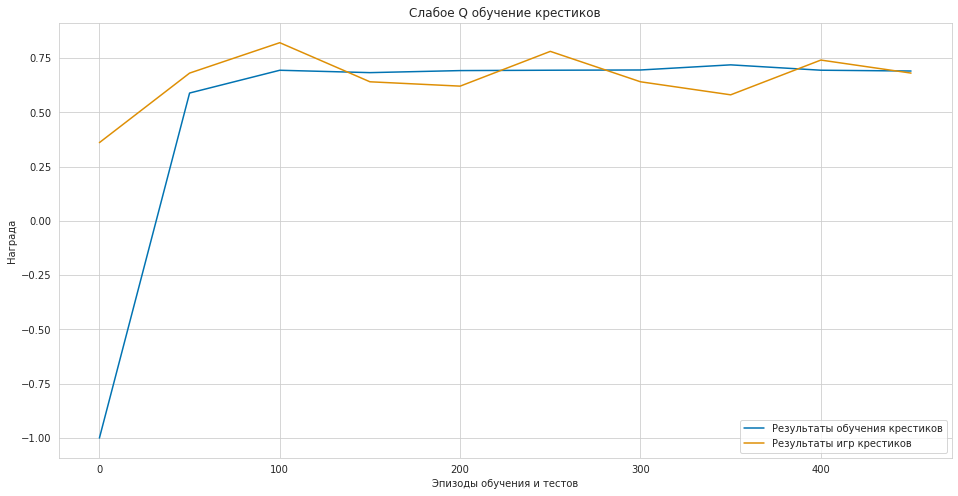

Средняя награда 0.654
Награда последнего эпизода 0.68


In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(episodes, reward_for_plot, label='Результаты обучения крестиков')
plt.plot(episodes, reward_for_plot_test, label='Результаты игр крестиков')
plt.xlabel('Эпизоды обучения и тестов')
plt.ylabel('Награда')
plt.title('Слабое Q обучение крестиков')
plt.legend()
plt.show()
print(f'Средняя награда {np.mean(reward_for_plot_test)}')
print(f'Награда последнего эпизода {reward_for_plot_test[-1]}')

In [ ]:
# Так как снова перехожу к отдельным обучениям, то награды ноликов опять отрицательные

a, e, g = 0.001, 0.05, 1.0
ql_0 = QL(alpha=a, epsilon=e, gamma=g, t=0)

reward_for_plot = []
reward_for_plot_test = []
episodes = []
episode = 0
cum_reward = 0

for n in tqdm.tqdm_notebook(range(5000)):
  steps, reward = q_learning_episode_0(env, ql_0)
  ql_0.learn_episode(steps, reward)
  cum_reward += reward
  if n % 50 == 0:
    reward_for_plot.append(cum_reward/(n + 1))
    episodes.append(episode)
    episode += 50

    cum_reward_test = 0
    for i in range(50):
      _, reward_test = q_playing_episode_0(env, ql_0)
      cum_reward_test += reward_test
    reward_for_plot_test.append(cum_reward_test/(i + 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


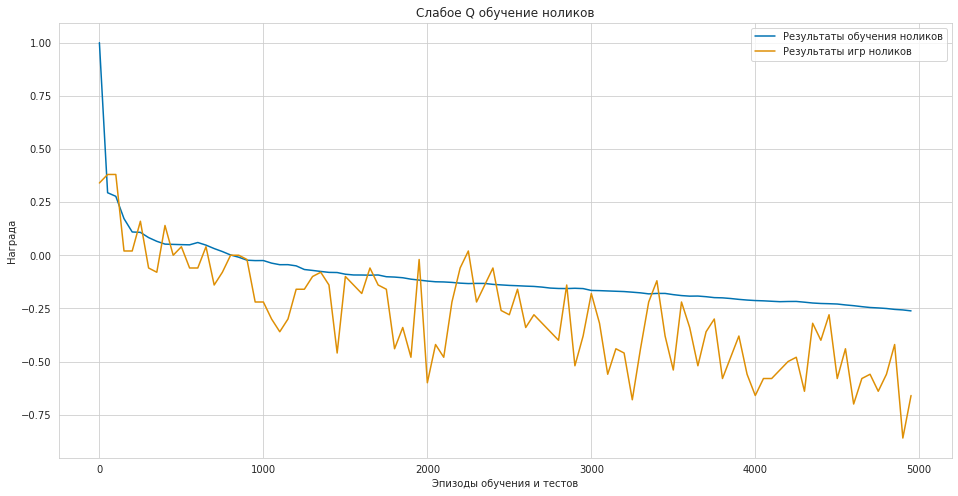

Средняя награда -0.2822
Награда последнего эпизода -0.66


In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(episodes, reward_for_plot, label='Результаты обучения ноликов')
plt.plot(episodes, reward_for_plot_test, label='Результаты игр ноликов')
plt.xlabel('Эпизоды обучения и тестов')
plt.ylabel('Награда')
plt.title('Слабое Q обучение ноликов')
plt.legend()
plt.show()
print(f'Средняя награда {np.mean(reward_for_plot_test)}')
print(f'Награда последнего эпизода {reward_for_plot_test[-1]}')

In [ ]:
# Отдельные функции создания роллаутов

def rollouts(env, action, pi, n_rollouts=100):
    rewards = []
    for i in range(n_rollouts):
        env_copy = copy.deepcopy(env)
        state, reward, done, _ = env_copy.step(action)
        text_state, available_states, curTurn = state
        while not done:
            if curTurn == 1:
                if text_state in pi.Q:
                    a = available_states[np.argmax(pi.Q[text_state])]
                else:
                    a = available_states[np.random.randint(len(available_states))]
                state, reward, done, _ = env_copy.step(a)
                text_state_next, available_states_next, curTurn_next = state
            else:
                a = available_states[np.random.randint(len(available_states))]
                state, reward, done, _ = env_copy.step(a)
                text_state_next, available_states_next, curTurn_next = state
            text_state, available_states, curTurn = text_state_next, available_states_next, curTurn_next
        rewards.append(reward)
    return np.array(rewards).mean()

def rollouts_0(env, action, pi, n_rollouts=100):
    rewards = []
    for i in range(n_rollouts):
        env_copy = copy.deepcopy(env)
        state, reward, done, _ = env_copy.step(action)
        text_state, available_states, curTurn = state
        while not done:
            if curTurn == 1:
                a = available_states[np.random.randint(len(available_states))]
                state, reward, done, _ = env_copy.step(a)
                text_state_next, available_states_next, curTurn_next = state
            else:
                if text_state in pi.Q:
                    a = available_states[np.argmin(pi.Q[text_state])]
                else:
                    a = available_states[np.random.randint(len(available_states))]
                state, reward, done, _ = env_copy.step(a)
                text_state_next, available_states_next, curTurn_next = state
            text_state, available_states, curTurn = text_state_next, available_states_next, curTurn_next
        rewards.append(reward)
    return np.array(rewards).mean()

In [ ]:
def play_game_with_rollouts(env, pi):
    env.reset()
    text_state, available_states, curTurn = env.getState()
    reward = 0
    done = False
    while not done:
        if curTurn == 1:
            best_reward = -10
            idx = 0
            for i, action in enumerate(available_states):
                avg_reward = rollouts(env, action, pi=pi, n_rollouts=100)
                if avg_reward > best_reward:
                    best_reward = avg_reward
                    idx = i
            a = available_states[idx]
            state, reward, done, _ = env.step(a)
            text_state_next, available_states_next, curTurn_next = state
        else:
            a = available_states[np.random.randint(len(available_states))]
            state, reward, done, _ = env.step(a)
            text_state_next, available_states_next, curTurn_next = state
        text_state, available_states, curTurn = text_state_next, available_states_next, curTurn_next
    return reward

def play_game_with_rollouts_0(env, pi):
    env.reset()
    text_state, available_states, curTurn = env.getState()
    reward = 0
    done = False
    while not done:
        if curTurn == 1:
            a = available_states[np.random.randint(len(available_states))]
            state, reward, done, _ = env.step(a)
            text_state_next, available_states_next, curTurn_next = state
        else:
            best_reward = 1
            idx = 0
            for i, action in enumerate(available_states):
                avg_reward = rollouts(env, action, pi=pi, n_rollouts=100)
                if avg_reward < best_reward and avg_reward >= -1:
                    best_reward = avg_reward
                    idx = i
            a = available_states[idx]
            state, reward, done, _ = env.step(a)
            text_state_next, available_states_next, curTurn_next = state
        text_state, available_states, curTurn = text_state_next, available_states_next, curTurn_next
    return reward

Проверяем крестики

In [ ]:
rewards = []
for _ in tqdm.tqdm_notebook(range(100)):
    reward = play_game_with_rollouts(env, pi=ql_x)
    rewards.append(reward)
print(f'Средняя награда {np.mean(rewards)}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Средняя награда 0.99


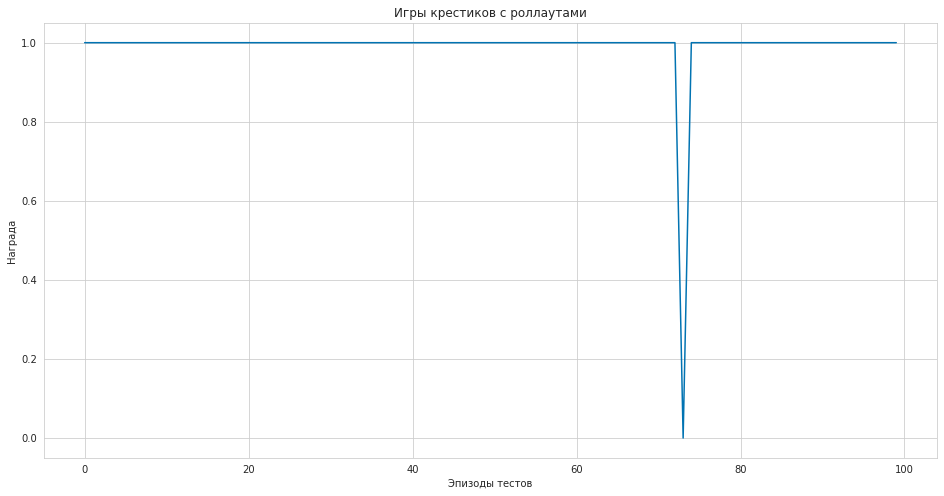

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(rewards)
plt.xlabel('Эпизоды тестов')
plt.ylabel('Награда')
plt.title('Игры крестиков с роллаутами')
plt.show()

Проверяем нолики

In [ ]:
rewards = []
for _ in tqdm.tqdm_notebook(range(100)):
    reward = play_game_with_rollouts_0(env, pi=ql_0)
    rewards.append(reward)
print(f'Средняя награда {np.mean(rewards)}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Средняя награда -0.78


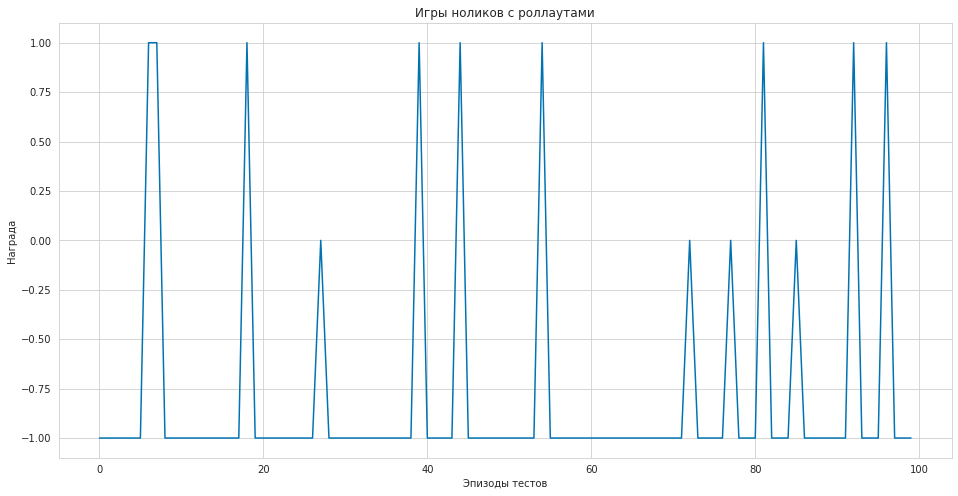

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(rewards)
plt.xlabel('Эпизоды тестов')
plt.ylabel('Награда')
plt.title('Игры ноликов с роллаутами')
plt.show()

Роллауты заметно улучшают результаты. Годная вещь!


6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

##Часть четвёртая, опциональная: AlphaZero

В опциональной части домашнего задания давайте попробуем всё-таки собрать всё вместе и завести настоящий AlphaZero. Если получится и будет обобщаться на большие доски, будет очень круто и будет стоить много дополнительных баллов.
7. Реализуйте AlphaZero для крестиков-ноликов, используя MCTS из третьей части и DQN-сеть из второй части. Обучите стратегии для игры на больших досках (10х10 и выше, до пяти в ряд; опять же, может потребовать много времени, так что достаточно показать, что обучение началось и идёт).
